In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install plot_keras_history

In [ ]:
!pip install neattext
!pip install wordcloud

## Import

In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np

from keras import layers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Reshape, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate, LSTM, Bidirectional
from keras.models import load_model
from keras.models import Model

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

import matplotlib.pyplot as plt
from plot_keras_history import plot_history
from tensorflow.keras.utils import plot_model


In [2]:
# To use GPU
import tensorflow as tf

print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load EDA Pkgs
import pandas as pd
import numpy as np

# Load Data Viz Pkgs
import seaborn as sns

# Load Text Cleaning Pkgs
import neattext.functions as nfx

# Load ML Pkgs
# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, plot_confusion_matrix

from textblob import TextBlob
from wordcloud import WordCloud


# Classification - High/Low Risk

## Load Dataset

In [4]:
# Load Dataset
df = pd.read_csv("Suicide_Detection_small.csv")
df.head()

,Unnamed: 0,text,class
0,0,Am I weird I don't get affected by compliments...,non-suicide
1,1,Finally 2020 is almost over... So I can never ...,non-suicide
2,2,i need helpjust help me im crying so hard,suicide
3,3,It ends tonight.I can’t do it anymore. \nI quit.,suicide
4,4,I took the rest of my sleeping pills and my pa...,suicide


In [5]:
labels=set(df["class"])
labels

{'non-suicide', 'suicide'}

non-suicide    52725
suicide        11643
Name: class, dtype: int64

<AxesSubplot:xlabel='class', ylabel='count'>

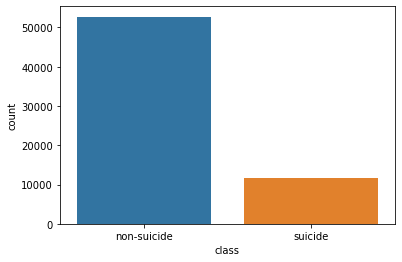

In [6]:
display(df["class"].value_counts())
# Plot
sns.countplot(x='class',data=df)

In [7]:
#Text Cleaning

# print(dir(nfx))
# User handles
df['Clean_Text'] = df['text'].apply(nfx.remove_userhandles)
# Stopwords
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_stopwords)
# remove punctuations
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_punctuations)
df

,Unnamed: 0,text,class,Clean_Text
0,0,Am I weird I don't get affected by compliments...,non-suicide,weird affected compliments coming know irl fee...
1,1,Finally 2020 is almost over... So I can never ...,non-suicide,Finally 2020 over hear 2020 bad year again swe...
2,2,i need helpjust help me im crying so hard,suicide,need helpjust help im crying hard
3,3,It ends tonight.I can’t do it anymore. \nI quit.,suicide,ends tonightI can’t anymore quit
4,4,I took the rest of my sleeping pills and my pa...,suicide,took rest sleeping pills painkillersI can’t wa...
...,...,...,...,...
64363,64363,Look what you all did!Its like im in the mirro...,suicide,Look didIts like im mirror im begging reflecti...
64364,64364,Anyone interested in joining a discord server?...,non-suicide,interested joining discord server 50+ members ...
64365,64365,Anyone wanna cry and hug for a few hours? I ha...,non-suicide,wanna cry hug hours particular reason maybe ea...
64366,64366,How ba-a-ad can i be? I’m just doin’ what come...,non-suicide,baaad be I’m doin’ comes naturally baaad be # ...


In [8]:
#Data Preprocessing 
y = df['class']
X = df['Clean_Text']
length = df['Clean_Text'].apply(len)
data = df.assign(Len_Situation=length)

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="C:/Users/SWONG/IS_Masters/PLP/Text Processing using Machine Learning/Day 2/Workshop/glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

vocabubary size: 40398
max length text: 70
0.4966334967077578


In [9]:
print("Maxlen: ", maxlen)
print("VocabSize: ", vocab_size)
print("embedding_dim: ", embedding_dim)
print("embedding_matrix shape: ", embedding_matrix.shape)
print("categories: ", len(labels))

Maxlen:  70
VocabSize:  40398
embedding_dim:  100
embedding_matrix shape:  (40398, 100)
categories:  2


In [10]:
##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot = y_train_onehot[:,1]
print(y_train_onehot.shape)
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot = y_test_onehot[:,1]
print(y_test_onehot.shape)

(45057,)
(19311,)


In [11]:
#create class weight dict for unbanlanced dataset
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights_d = dict(enumerate(class_weights))
class_weights_d

{0: 0.6103795822157198, 1: 2.7649116347569955}

## CNN

### Shallow CNN

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 100)           4039800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 68, 512)           154112    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 4,194,425
Trainable params: 154,625
Non-trainable params: 4,039,800
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/25
705/705 [==============================] - 7s 9ms/step 

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

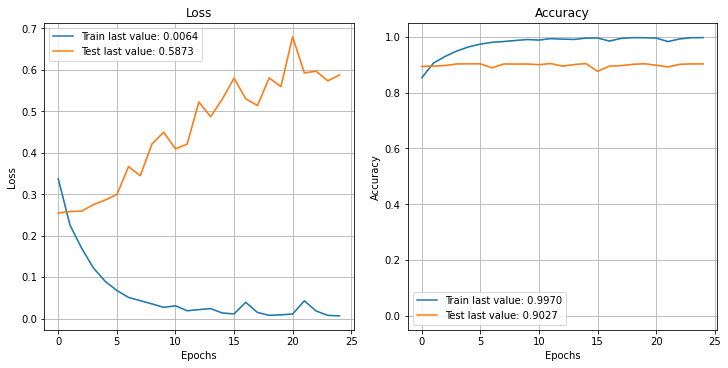

In [21]:
# Shallow CNN
shallow_CNN = Sequential()
shallow_CNN.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
shallow_CNN.add(Conv1D(512, 3, activation='relu'))
shallow_CNN.add(GlobalMaxPooling1D())
shallow_CNN.add(Dense(1, activation='sigmoid'))
shallow_CNN.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])
shallow_CNN.summary()

plot_model(shallow_CNN, 
           to_file='./shallow_cnn.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

#train the model
hist_shallow = shallow_CNN.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=25,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = shallow_CNN.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = shallow_CNN.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_shallow)

In [23]:
shallow_CNN.save('shallow_cnn.h5')

# Modified Shallow CNN with Dropout

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 100)           4039800   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 68, 512)           154112    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,226,809
Trainable params: 187,009
Non-trainable params: 4,039,800
______________________________________

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

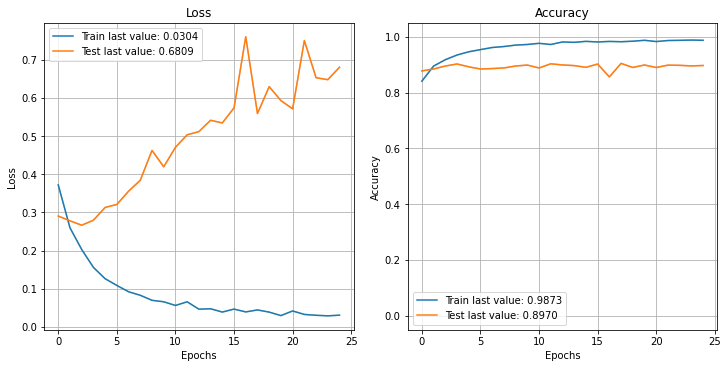

In [24]:
#Modified Shallow CNN with Dropout
shallow_do = Sequential()
shallow_do.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#trigram. #kernels/filters=512
shallow_do.add(Conv1D(512, 3, activation='relu'))
shallow_do.add(GlobalMaxPooling1D())
shallow_do.add(Dense(64, activation='relu'))
shallow_do.add(Dropout(0.5))
shallow_do.add(Dense(1, activation='sigmoid'))
shallow_do.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])
shallow_do.summary()
plot_model(shallow_do, 
           to_file='./shallow_do.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

#train the model

hist_shallow_do = shallow_do.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=25,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = shallow_do.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = shallow_do.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_shallow_do)

In [25]:
shallow_do.save('shallow_cnn_dp.h5')

### Deep CNN

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 70, 100)      4039800     input_1[0][0]                    
______________________________________________________________________________________________

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

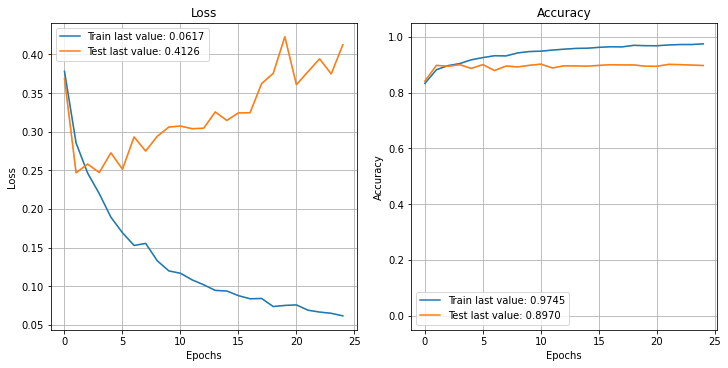

In [26]:
##Deep CNN 
# define the model
from keras.layers.merge import concatenate

def define_model(length, vocab_size,embedding_dim):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs1)
    conv1 = Conv1D(filters=128, kernel_size=2, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs2)
    conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs3)
    conv3 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(64, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())
    return model

deep = define_model(maxlen,vocab_size,embedding_dim)
#train the model

plot_model(deep, 
           to_file='./model_deep.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
hist_deep = deep.fit([X_train,X_train,X_train], y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=25,
                    verbose=True,
                    validation_data=([X_test,X_test,X_test], y_test_onehot),
                    batch_size=64).history

loss, accuracy = deep.evaluate([X_train,X_train,X_train], y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = deep.evaluate([X_test,X_test,X_test], y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_deep)

In [27]:
deep.save('deep_cnn.h5')

### BiLSTM - output Dropout

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 100)           4039800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 4,124,409
Trainable params: 84,609
Non-trainable params: 4,039,800
_________________________________________________________________
Train...
Epoch 1/25
705/705 [==============================] - 20s 25ms/step - loss: 0.4180 - accuracy: 0.8033 - val_loss: 0.3387 - val_accuracy: 0.8517
Epoch 2/25
705/705 [==============================] - 16s 23ms/step - loss: 0.3160 -

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

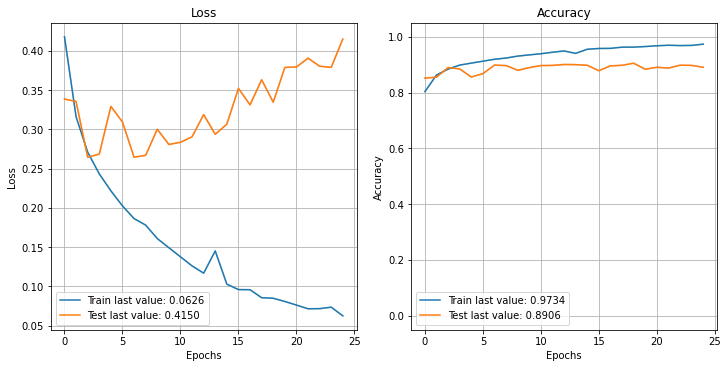

In [14]:
#Define the BiLSTM model with output Dropout
##############################################
bilstm_out_dp = Sequential()
bilstm_out_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
bilstm_out_dp.add(Bidirectional(LSTM(64)))
#output Dropout
bilstm_out_dp.add(Dropout(0.5))
bilstm_out_dp.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
bilstm_out_dp.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
bilstm_out_dp.summary()

#Train the model
batch_size = 64

print('Train...')
hist_bilstm_out_dp = bilstm_out_dp.fit(X_train, y_train_onehot,
          class_weight = class_weights_d,
          batch_size=batch_size,
          epochs=25,
          validation_data=(X_test, y_test_onehot)).history

loss, accuracy = bilstm_out_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = bilstm_out_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_bilstm_out_dp)

In [28]:
bilstm_out_dp.save('bilstm_output_dp.h5')

### BiLSTM - Input Dropout

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 70, 100)           4039800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 4,124,409
Trainable params: 84,609
Non-trainable params: 4,039,800
_________________________________________________________________
Train...
Epoch 1/25
705/705 [==============================] - 18s 22ms/step - loss: 0.4492 - accuracy: 0.7803 - val_loss: 0.4850 - val_accuracy: 0.7672
Epoch 2/25
705/705 [==============================] - 15s 21ms/step - loss: 0.3545 - accuracy: 0.8419 - val_loss: 0.5823 - val_accuracy: 0.7269
Epoch 3/25
705/705 [==============================] - 15s 21ms/step - lo

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

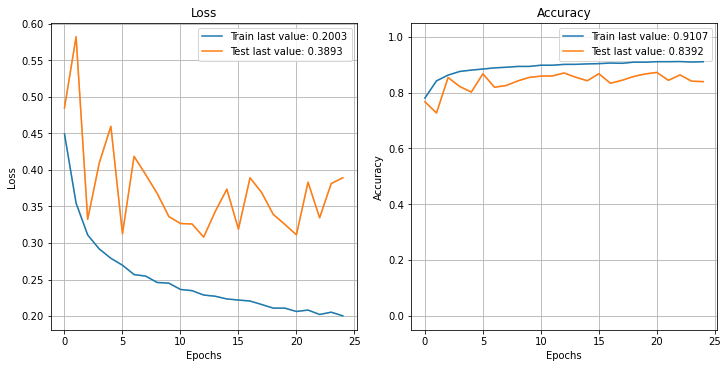

In [29]:
#Input Layer Dropout. 
###############################################################################
bilstm_in_dp = Sequential()
bilstm_in_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout
bilstm_in_dp.add(Bidirectional(LSTM(64,dropout=0.5)))
bilstm_in_dp.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
bilstm_in_dp.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
bilstm_in_dp.summary()

#Train the model
batch_size = 64

print('Train...')
hist_bilstm_in_dp = bilstm_in_dp.fit(X_train, y_train_onehot,
          class_weight = class_weights_d,
          batch_size=batch_size,
          epochs=25,
          validation_data=(X_test, y_test_onehot)).history

loss, accuracy = bilstm_in_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = bilstm_in_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_bilstm_in_dp)

In [30]:
bilstm_in_dp.save('bilstm_input_dp.h5')

### BiLSTM - Recurrent Dropout

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 100)           4039800   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 4,124,409
Trainable params: 84,609
Non-trainable params: 4,039,800
_________________________________________________________________
Train...
Epoch 1/25
705/705 [==============================] - 675s 953ms/step - loss: 0.3976 - accuracy: 0.8168 - val_loss: 0.3419 - val_accuracy: 0.8493
Epoch 2/25
705/705 [==============================] - 798s 1s/step - loss: 0.2884 - accuracy: 0.8771 - val_loss: 0.3537 - val_accuracy: 0.8455
Epoch 3/25
705/705 [==============================] - 874s 1s/step - loss

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

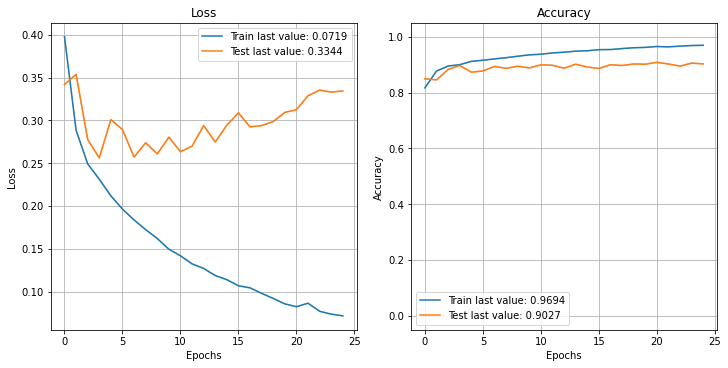

In [12]:
#recurent_dropout
###############################################################################
bilstm_rec_dp = Sequential()
bilstm_rec_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#recurent_dropout
bilstm_rec_dp.add(Bidirectional(LSTM(64,recurrent_dropout=0.5)))
bilstm_rec_dp.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
bilstm_rec_dp.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
bilstm_rec_dp.summary()
#Train the model
batch_size = 64

print('Train...')
hist_bilstm_rec_dp = bilstm_rec_dp.fit(X_train, y_train_onehot,
          class_weight = class_weights_d,
          batch_size=batch_size,
          epochs=25,
          validation_data=(X_test, y_test_onehot)).history

loss, accuracy = bilstm_rec_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = bilstm_rec_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_bilstm_rec_dp)


In [15]:
bilstm_rec_dp.save('bilstm_rec_dp.h5')

### BiLSTM with all dropout to predict suicide/non-suicide

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 70, 100)           4039800   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 4,124,409
Trainable params: 84,609
Non-trainable params: 4,039,800
_________________________________________________________________
Train...
Epoch 1/25
705/705 [==============================] - 716s 1s/step - loss: 0.4790 - accuracy: 0.7563 - val_loss: 0.4054 - val_accuracy: 0.8114
Epoch 2/25
705/705 [==============================] - 740s 1s/step - loss: 0.3969 - a

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

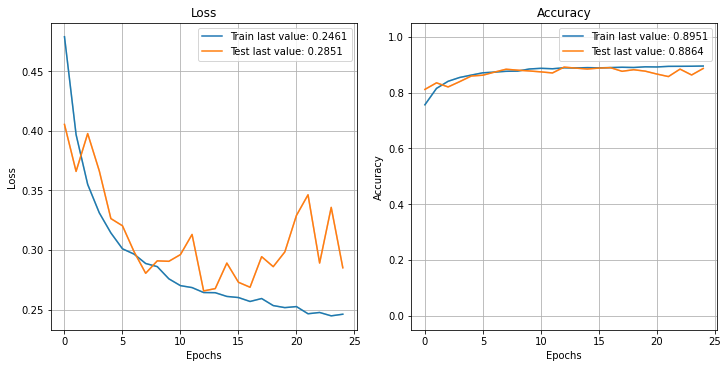

In [31]:
#Combain all dropout
##############################################################################
bilstm_all_dp = Sequential()
bilstm_all_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout and rec Dropout
bilstm_all_dp.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
#output Dropout
bilstm_all_dp.add(Dropout(0.5))
bilstm_all_dp.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
bilstm_all_dp.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
bilstm_all_dp.summary()

#Train the model
batch_size = 64

print('Train...')
hist_bilstm_all_dp = bilstm_all_dp.fit(X_train, y_train_onehot,
          class_weight = class_weights_d,                             
          batch_size=batch_size,
          epochs=25,
          validation_data=(X_test, y_test_onehot)).history

loss, accuracy = bilstm_all_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = bilstm_all_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_bilstm_all_dp)

In [32]:
bilstm_all_dp.save('bilstm_all_dp.h5')

### Compare all models

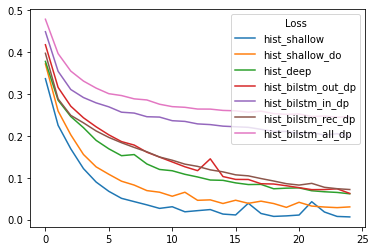

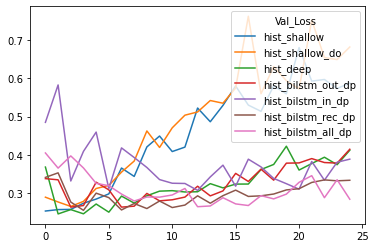

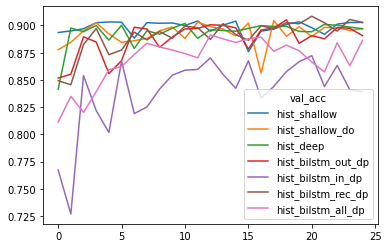

In [33]:
#Compare all the models
import matplotlib.pyplot as plt

plt.plot(hist_shallow['loss'], label='hist_shallow')
plt.plot(hist_shallow_do['loss'], label='hist_shallow_do')
plt.plot(hist_deep['loss'], label='hist_deep')
plt.plot(hist_bilstm_out_dp['loss'], label='hist_bilstm_out_dp')
plt.plot(hist_bilstm_in_dp['loss'], label='hist_bilstm_in_dp')
plt.plot(hist_bilstm_rec_dp['loss'], label='hist_bilstm_rec_dp')
plt.plot(hist_bilstm_all_dp['loss'], label='hist_bilstm_all_dp')
plt.legend(loc='upper right', title="Loss")
plt.show()

plt.plot(hist_shallow['val_loss'], label='hist_shallow')
plt.plot(hist_shallow_do['val_loss'], label='hist_shallow_do')
plt.plot(hist_deep['val_loss'], label='hist_deep')
plt.plot(hist_bilstm_out_dp['val_loss'], label='hist_bilstm_out_dp')
plt.plot(hist_bilstm_in_dp['val_loss'], label='hist_bilstm_in_dp')
plt.plot(hist_bilstm_rec_dp['val_loss'], label='hist_bilstm_rec_dp')
plt.plot(hist_bilstm_all_dp['val_loss'], label='hist_bilstm_all_dp')
plt.legend(loc='upper right', title="Val_Loss")
plt.show()

plt.plot(hist_shallow['val_accuracy'], label='hist_shallow')
plt.plot(hist_shallow_do['val_accuracy'], label='hist_shallow_do')
plt.plot(hist_deep['val_accuracy'], label='hist_deep')
plt.plot(hist_bilstm_out_dp['val_accuracy'], label='hist_bilstm_out_dp')
plt.plot(hist_bilstm_in_dp['val_accuracy'], label='hist_bilstm_in_dp')
plt.plot(hist_bilstm_rec_dp['val_accuracy'], label='hist_bilstm_rec_dp')
plt.plot(hist_bilstm_all_dp['val_accuracy'], label='hist_bilstm_all_dp')
plt.legend(loc='lower right', title = 'val_acc')
plt.show()

# Taking the best model (bilstm_rec_dp, 10 epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 100)           4039800   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 4,124,409
Trainable params: 84,609
Non-trainable params: 4,039,800
_________________________________________________________________
Train...
Epoch 1/10
705/705 [==============================] - 669s 941ms/step - loss: 0.4030 - accuracy: 0.8105 - val_loss: 0.3826 - val_accuracy: 0.8243
Epoch 2/10
705/705 [==============================] - 845s 1s/step - loss: 0.2930 - accuracy: 0.8731 - val_loss: 0.2980 - val_accuracy: 0.8743
Epoch 3/10
705/705 [==============================] - 813s 1s/step - loss

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

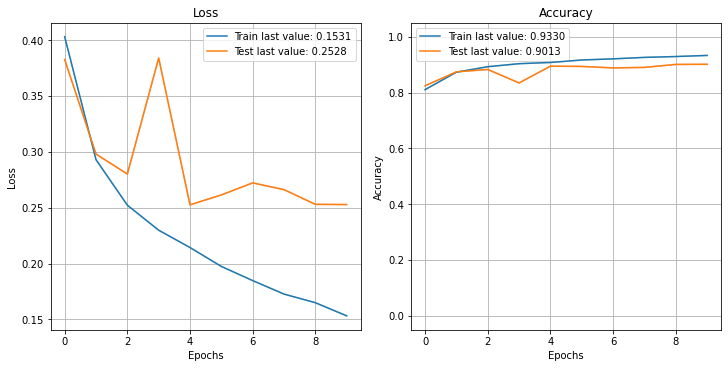

In [12]:
#recurent_dropout
###############################################################################
bilstm_rec_dp = Sequential()
bilstm_rec_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#recurent_dropout
bilstm_rec_dp.add(Bidirectional(LSTM(64,recurrent_dropout=0.5)))
bilstm_rec_dp.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
bilstm_rec_dp.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
bilstm_rec_dp.summary()
#Train the model
batch_size = 64

print('Train...')
hist_bilstm_rec_dp = bilstm_rec_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=10,
          class_weight = class_weights_d,
          validation_data=(X_test, y_test_onehot)).history

loss, accuracy = bilstm_rec_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = bilstm_rec_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_bilstm_rec_dp)


In [14]:
bilstm_rec_dp.save('bilstm_rec_dp_best.h5')

# Evaluate the model

In [16]:
y_pred = bilstm_rec_dp.predict(X_test)
y_pred_bin = np.empty([y_pred.shape[0]])
for i, pred in enumerate(y_pred):
    if pred<0.5: # using a threshold of 0.2 to increase the recall of the high-risk class
        y_pred_bin[i] = 0
    else:
        y_pred_bin[i] = 1
print(confusion_matrix(y_test_onehot, y_pred_bin))

[[14784  1032]
 [  874  2621]]


In [17]:
accuracy_score(y_test_onehot, y_pred_bin)

0.9012997773289835

In [18]:
print(classification_report(y_test_onehot, y_pred_bin, target_names=["Low Risk","High Risk"]))

              precision    recall  f1-score   support

    Low Risk       0.94      0.93      0.94     15816
   High Risk       0.72      0.75      0.73      3495

    accuracy                           0.90     19311
   macro avg       0.83      0.84      0.84     19311
weighted avg       0.90      0.90      0.90     19311

